In [3]:
import os
import csv
import sys
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector as sql
from dotenv import load_dotenv

from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR

warnings.filterwarnings('ignore')

dotenv_path = "../.env"
load_dotenv(dotenv_path)

True

In [4]:
# make a connection to the database
dwh = sql.connect(
    host="127.0.0.1",   # ip-adres
    port=3306,   # poortnummer
    user=os.getenv("USER"),   # username
    password=os.getenv("PASSWORD"),   # wachtwoord
    database="AirFaresDWH"   # naam van de datawarehouse in mysql workbench
    # database="groep8dep"   # naam van de OLTP database in mysql workbench
)

# check if the connection succeeded
print(dwh)

In [5]:
# create cursor
cursor = dwh.cursor()

# use the right database
cursor.execute("USE AirFaresDWH")

# get the column names
cursor.execute("SELECT COLUMN_NAME FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'dimairline'")
columns_airline = cursor.fetchall()

cursor.execute("SELECT COLUMN_NAME FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'dimairport'")
columns_airport = cursor.fetchall()

cursor.execute("SELECT COLUMN_NAME FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'dimdate'")
columns_date = cursor.fetchall()

cursor.execute("SELECT COLUMN_NAME FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'dimflight'")
columns_flight = cursor.fetchall()

cursor.execute("SELECT COLUMN_NAME FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'factflightfare'")
columns_fact = cursor.fetchall()


# get all the data
cursor.execute("SELECT * FROM dimairline")
rows_airline = cursor.fetchall()

cursor.execute("SELECT * FROM dimairport")
rows_airport = cursor.fetchall()

cursor.execute("SELECT * FROM dimdate")
rows_date = cursor.fetchall()

cursor.execute("SELECT * FROM dimflight")
rows_flight = cursor.fetchall()

cursor.execute("SELECT * FROM factflightfare")
rows_fact = cursor.fetchall()


# remove the first line with null values
rows_airline = rows_airline[1:]
rows_airport = rows_airport[1:]
rows_date = rows_date[1:]
rows_flight = rows_flight[1:]
rows_fact = rows_fact[1:]

# create dataframes
# df_airline = pd.DataFrame(rows_airline, columns=[i[0] for i in columns_airline])
# df_airport = pd.DataFrame(rows_airport, columns=[i[0] for i in columns_airport])
# df_date = pd.DataFrame(rows_date, columns=[i[0] for i in columns_date])
# df_flight = pd.DataFrame(rows_flight, columns=[i[0] for i in columns_flight])
# df_fact = pd.DataFrame(rows_fact, columns=[i[0] for i in columns_fact])

# create a new dataframe with all the data
# df = pd.merge(df_fact, df_flight, on='flight_key')
# df = pd.merge(df, df_airline, on='airline_key')
# df = pd.merge(df, df_airport, left_on='depatureAirportKey', right_on='airport_key')
# df = pd.merge(df, df_airport, left_on='arrivalAirportKey', right_on='airport_key', how='inner')
# df = pd.merge(df, df_date, left_on='scrapeDateKey', right_on='date_key')
# df = pd.merge(df, df_date, left_on='departureDateKey', right_on='date_key')
# df = pd.merge(df, df_date, left_on='arrivalDateKey', right_on='date_key')

# create the query to connect the tables
query = """
SELECT * FROM factflightfare
INNER JOIN dimflight ON factflightfare.flight_key = dimflight.flight_key
INNER JOIN dimairline ON factflightfare.airline_key = dimairline.airline_key
INNER JOIN dimairport AS dep_airport ON factflightfare.depatureAirportKey = dep_airport.airport_key
INNER JOIN dimairport AS arr_airport ON factflightfare.arrivalAirportKey = arr_airport.airport_key
INNER JOIN dimdate AS scrape_date ON factflightfare.scrapeDateKey = scrape_date.date_key
INNER JOIN dimdate AS dep_date ON factflightfare.departureDateKey = dep_date.date_key
INNER JOIN dimdate AS arr_date ON factflightfare.arrivalDateKey = arr_date.date_key
"""

# create the dataframe
df = pd.read_sql(query, dwh)

# check if there are duplicate columns, if so drop them
df = df.loc[:,~df.columns.duplicated()]

# show the columns of the df
print(df.columns)

# show the df
df

Index(['flightfare_key', 'flight_key', 'airline_key', 'depatureAirportKey',
       'arrivalAirportKey', 'scrapeDateKey', 'departureDateKey',
       'arrivalDateKey', 'availableSeats', 'price', 'flight_id',
       'flightnumber', 'numberOfStops', 'departureTime', 'arrivalTime',
       'duration', 'start_date', 'end_date', 'airline_iata_code',
       'airline_name', 'country', 'airport_key', 'airport_iata_code',
       'airport_name', 'location', 'date_key', 'date', 'day_of_week',
       'day_of_month', 'day_of_year', 'year', 'dayName', 'monthName',
       'nameOfQuarter', 'numberOfQuarter', 'isWeekend', 'isWeekDay',
       'isHoliday'],
      dtype='object')


,flightfare_key,flight_key,airline_key,depatureAirportKey,arrivalAirportKey,scrapeDateKey,departureDateKey,arrivalDateKey,availableSeats,price,...,day_of_month,day_of_year,year,dayName,monthName,nameOfQuarter,numberOfQuarter,isWeekend,isWeekDay,isHoliday
0,1,2,1,5,1,20230411,20230417,20230417,1,119.43,...,11,101,2023,Tuesday,April,Q2,2,0,1,1
1,2,7,1,5,1,20230412,20230430,20230430,-1,247.79,...,12,102,2023,Wednesday,April,Q2,2,0,1,1
2,3,14,1,5,1,20230415,20230515,20230515,-1,168.99,...,15,105,2023,Saturday,April,Q2,2,1,0,1
3,4,26,1,5,1,20230423,20230612,20230612,1,58.87,...,23,113,2023,Sunday,April,Q2,2,1,0,0
4,5,47,1,5,1,20230407,20230731,20230731,2,161.84,...,7,97,2023,Friday,April,Q2,2,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120154,120155,5498,4,13,17,20230426,20230712,20230712,-1,309.99,...,26,116,2023,Wednesday,April,Q2,2,0,1,0
120155,120156,5498,4,13,17,20230430,20230712,20230712,-1,319.99,...,30,120,2023,Sunday,April,Q2,2,1,0,0
120156,120157,5498,4,13,17,20230423,20230712,20230712,-1,309.99,...,23,113,2023,Sunday,April,Q2,2,1,0,0
120157,120158,5498,4,13,17,20230418,20230712,20230712,-1,309.99,...,18,108,2023,Tuesday,April,Q2,2,0,1,0


# Is er een correlatie met de vakantiebestemmingen: zijn bepaalde bestemmingen significant duurder dan andere bestemmingen? Vraag 7

<Axes: xlabel='arrivalAirportKey', ylabel='price'>

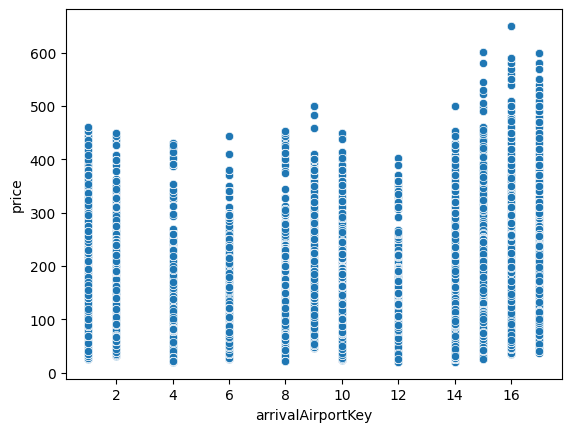

In [6]:
sns.scatterplot(data=df, x="arrivalAirportKey", y="price")

In [7]:
corr = np.corrcoef(df["arrivalAirportKey"], df["price"])

In [8]:
print("de correlatie tussen arrivalAirportKey en price is: ", corr)

de correlatie tussen arrivalAirportKey en price is:  [[1.         0.19854777]
 [0.19854777 1.        ]]


In [9]:
df.corr()

,flightfare_key,flight_key,airline_key,depatureAirportKey,arrivalAirportKey,scrapeDateKey,departureDateKey,arrivalDateKey,availableSeats,price,...,airport_key,date_key,day_of_week,day_of_month,day_of_year,year,numberOfQuarter,isWeekend,isWeekDay,isHoliday
flightfare_key,1.000000,0.003619,0.004015,0.004829,0.005741,0.002916,-0.016834,-0.016834,0.000758,0.006673,...,0.004829,0.002916,-0.001534,0.002916,0.002916,NaN,NaN,0.000762,-0.000762,-0.003371
flight_key,0.003619,1.000000,0.903810,0.383538,0.272093,-0.007810,0.044694,0.044694,-0.355114,0.469871,...,0.383538,-0.007810,-0.004019,-0.007810,-0.007810,NaN,NaN,-0.004374,0.004374,0.000812
airline_key,0.004015,0.903810,1.000000,0.081595,0.051698,-0.005048,0.035814,0.035814,-0.404299,0.507014,...,0.081595,-0.005048,-0.002564,-0.005048,-0.005048,NaN,NaN,-0.003044,0.003044,0.000367
depatureAirportKey,0.004829,0.383538,0.081595,1.000000,0.042927,0.001255,-0.045989,-0.045989,-0.115057,-0.022507,...,1.000000,0.001255,-0.000264,0.001255,0.001255,NaN,NaN,-0.000066,0.000066,-0.002818
arrivalAirportKey,0.005741,0.272093,0.051698,0.042927,1.000000,-0.007481,0.009672,0.009672,-0.048102,0.198548,...,0.042927,-0.007481,-0.003725,-0.007481,-0.007481,NaN,NaN,-0.002680,0.002680,0.001157
scrapeDateKey,0.002916,-0.007810,-0.005048,0.001255,-0.007481,1.000000,0.065137,0.065137,0.002624,0.033367,...,0.001255,1.000000,-0.012876,1.000000,1.000000,NaN,NaN,0.051828,-0.051828,-0.856214
departureDateKey,-0.016834,0.044694,0.035814,-0.045989,0.009672,0.065137,1.000000,1.000000,-0.105397,-0.152483,...,-0.045989,0.065137,0.000844,0.065137,0.065137,NaN,NaN,0.001124,-0.001124,-0.057964
arrivalDateKey,-0.016834,0.044694,0.035814,-0.045989,0.009672,0.065137,1.000000,1.000000,-0.105397,-0.152483,...,-0.045989,0.065137,0.000844,0.065137,0.065137,NaN,NaN,0.001124,-0.001124,-0.057964
availableSeats,0.000758,-0.355114,-0.404299,-0.115057,-0.048102,0.002624,-0.105397,-0.105397,1.000000,-0.151042,...,-0.115057,0.002624,0.000144,0.002624,0.002624,NaN,NaN,-0.000380,0.000380,-0.001674
price,0.006673,0.469871,0.507014,-0.022507,0.198548,0.033367,-0.152483,-0.152483,-0.151042,1.000000,...,-0.022507,0.033367,-0.001091,0.033367,0.033367,NaN,NaN,-0.003373,0.003373,-0.034792


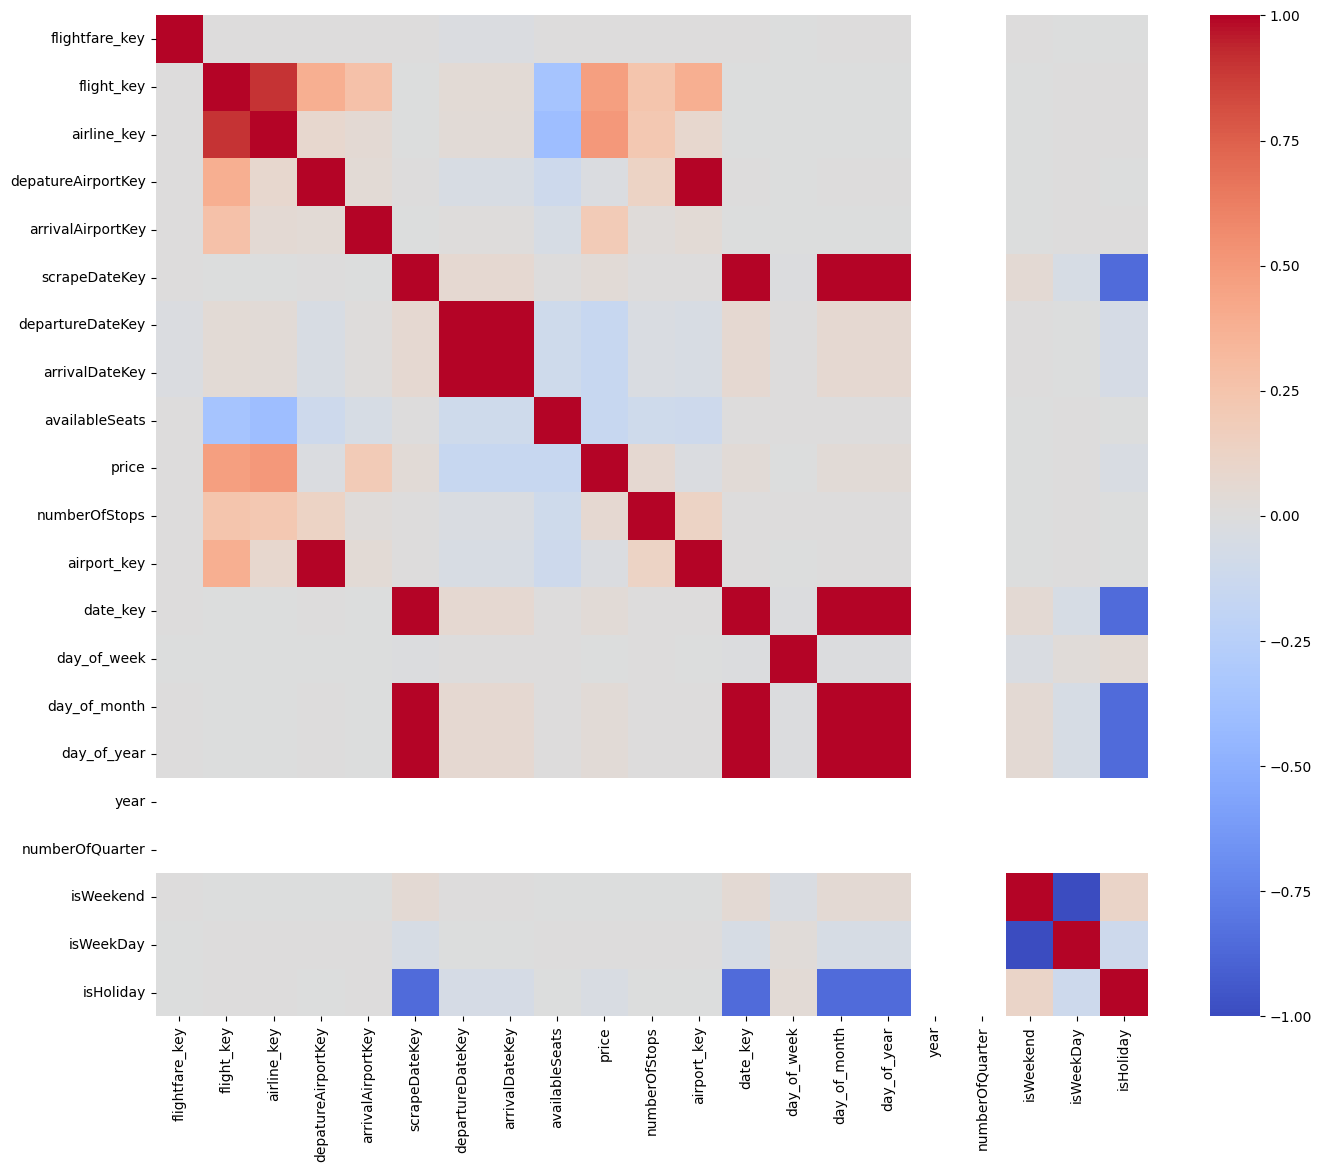

In [10]:
plt.figure(figsize=(16, 13))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm")
plt.show()

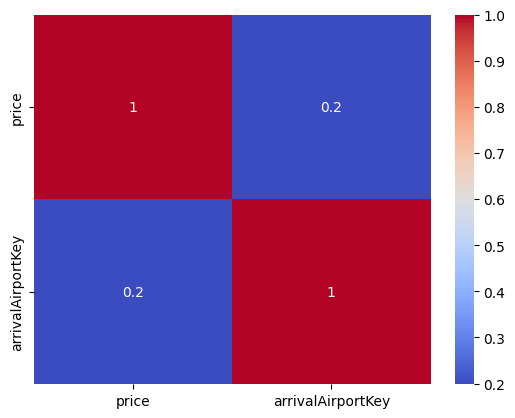

In [11]:
cols = ['price', 'arrivalAirportKey']

corr_matrix = df[cols].corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

# Vraag 8 - Zijn de prijzen gerelateerd aan vakantieperiodes hier of ter plaatse?

In [15]:
import pandas as pd

isHoliday = df["isHoliday"].astype(str)
monthName = df["monthName"].astype(str)

# Bereken de gemiddelde prijzen per kwartaal
vakantie_gemiddelde = df.groupby("isHoliday")["price"].mean()
# Vergelijk de gemiddelde prijzen per kwartaal en maand met de gemiddelde prijzen buiten vakantieperiodes
print("Gemiddelde prijzen per Vakantie:\n", vakantie_gemiddelde)

Gemiddelde prijzen per Vakantie:
 isHoliday
0    165.190846
1    159.402946
Name: price, dtype: float64


# Vraag 9 - Kan je de prijsstrategie afleiden? (Invloed van aantal dagen voor vertrek, invloed van beschikbaarheid)

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

vandaag = datetime.datetime.now()
vertrekdatum = df['departureDateKey']

dagen_voor_vertrek = (vertrekdatum - vandaag)

print(dagen_voor_vertrek)


# # Plot de gemiddelde prijs per aantal dagen tot vertrek
# plt.scatter(df['Days_to_departure'], df['Price'])
# plt.xlabel('Dagen tot vertrek')
# plt.ylabel('Prijs')
# plt.show()

# # Bereken de gemiddelde prijs per aantal dagen tot vertrek en beschikbaarheid
# price_by_days_and_availability = df.groupby(['Days_to_departure', 'Availability'])['Price'].mean()
# print(price_by_days_and_availability)


0        -19489 days +13:35:53.977044417
1        -19489 days +13:35:53.977044430
2        -19489 days +13:35:53.977044515
3        -19489 days +13:35:53.977044612
4        -19489 days +13:35:53.977044731
                       ...              
120154   -19489 days +13:35:53.977044712
120155   -19489 days +13:35:53.977044712
120156   -19489 days +13:35:53.977044712
120157   -19489 days +13:35:53.977044712
120158   -19489 days +13:35:53.977044712
Name: departureDateKey, Length: 120159, dtype: timedelta64[ns]
